<a href="https://colab.research.google.com/github/spr88p50/detectron2/blob/main/WaveDetection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, distutils.core, json, random
from random import randint
import time
import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
from google.colab.patches import cv2_imshow
from google.colab import drive

# google driveをマウントする
drive.mount('/content/drive')

# google driveのPATHを通す
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# 必要パッケージインストール
!git clone 'https://github.com/facebookresearch/detectron2' -q
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} -q
!python -m pip install pyyaml -q

# detectron2のPATHを通す
sys.path.insert(0, os.path.abspath('./detectron2'))

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# detectron2の設定を一部書き換える
!cp '/content/drive/MyDrive/detectron2_mod_file/visualizer.py' '/content/detectron2/detectron2/utils/visualizer.py'
!cp '/content/drive/MyDrive/detectron2_mod_file/video_visualizer.py' '/content/detectron2/detectron2/utils/video_visualizer.py'
!cp '/content/drive/MyDrive/detectron2_mod_file/colormap.py' '/content/detectron2/detectron2/utils/colormap.py'

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.engine.hooks import HookBase
from detectron2.config import get_cfg
import detectron2.utils.comm as comm
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_context, inference_on_dataset, COCOEvaluator

１　Val lossを計算するカスタムフックをTrainerに実装

In [3]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


# TrainerにLossEvalHookクラスをhookとして加える
class Trainer(DefaultTrainer):
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

２　データ準備

波映像の画像データセットを用意．各画像には波が高く見えるところをセグメンテーションした．jsonファイルには各画像のAnnotation（波が高いところ）がCOCOフォーマットで設定．ただし300.jpg～700.jpgにはAnnotationはない．テスト用に使用．

In [4]:
!wget https://github.com/spr88p50/object-detection/blob/main/wave.zip?raw=true -q -O wave.zip
!unzip wave.zip  > /dev/null

３　データセットの登録

In [4]:
register_coco_instances("wave", {}, "/content/drive/MyDrive/wave_merge/wave_merge.json", "./drive/MyDrive/wave_merge")
register_coco_instances("wave_val", {}, "/content/drive/MyDrive/wave_val/wave_val.json", "./drive/MyDrive/wave_val")

４　データセットが正しく登録されているか確認

In [5]:
metadata = MetadataCatalog.get("__nonexist__")
metadata.get('things_colors')

WARNING [03/05 03:31:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/05 03:31:59 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/drive/MyDrive/wave_val/wave_val.json


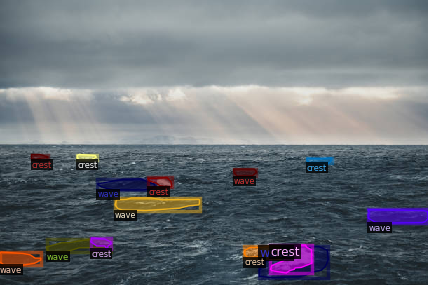

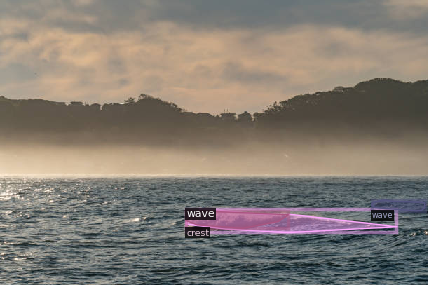

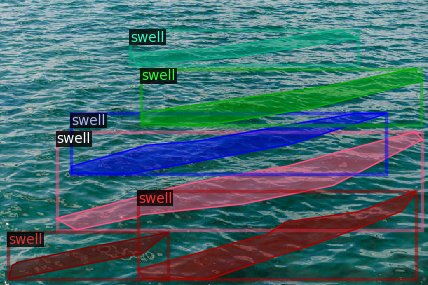

In [7]:
wave_metadata = MetadataCatalog.get("wave_val")
dataset_dicts = DatasetCatalog.get("wave_val")

for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=wave_metadata, scale=0.7)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

５　学習

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wave",)
cfg.DATASETS.TEST = ("wave_val",)  # <- choose
# cfg.DATASETS.TEST = ()  # val lossを確認しないときはこちらを選択し、cfg.TEST.EVAL_PERIODをコメントアウトすること
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0004
cfg.SOLVER.MAX_ITER = (1000)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 出力のクラス数
# cfg.SOLVER.CHECKPOINT_PERIOD = 100  # 100イテレーションごとにcheckpointをgetする

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = Trainer(cfg)  # <- choose
trainer.resume_or_load(resume=False)
trainer.train()

[03/05 04:42:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 165MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/05 04:42:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/05 04:42:35 d2.utils.events]:  eta: 0:06:17  iter: 19  total_loss: 4.764  loss_cls: 1.459  loss_box_reg: 0.4764  loss_rpn_cls: 2.452  loss_rpn_loc: 0.2951    time: 0.6383  last_time: 0.4303  data_time: 0.2483  last_data_time: 0.0066   lr: 7.9924e-06  max_mem: 2545M
[03/05 04:42:47 d2.utils.events]:  eta: 0:06:37  iter: 39  total_loss: 4.144  loss_cls: 1.217  loss_box_reg: 0.5554  loss_rpn_cls: 1.906  loss_rpn_loc: 0.2559    time: 0.5223  last_time: 0.4941  data_time: 0.0081  last_data_time: 0.0081   lr: 1.5984e-05  max_mem: 2638M
[03/05 04:42:55 d2.utils.events]:  eta: 0:06:25  iter: 59  total_loss: 2.595  loss_cls: 0.965  loss_box_reg: 0.609  loss_rpn_cls: 0.597  loss_rpn_loc: 0.2647    time: 0.4823  last_time: 0.4338  data_time: 0.0085  last_data_time: 0.0065   lr: 2.3976e-05  max_mem: 2639M
[03/05 04:43:03 d2.utils.events]:  eta: 0:06:10  iter: 79  total_loss: 2.099  loss_cls: 0.8061  loss_box_reg: 0.7648  loss_rpn_cls: 0.2658  loss_rpn_loc: 0.2288    time: 0.4629  last_time: 0.

KeyboardInterrupt: 

６　学習の推移を確認

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [6]:
# Plot Train/Validation loss together
experiment_folder = '/content/output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x["iteration"] for x in experiment_metrics],
    [round(x["total_loss"], 2) for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x],
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()
plt.savefig("./output/train_val_loss.png")

KeyError: 'total_loss'

７　推論

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 出力のクラス数
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/pth_wave/model_final_6.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

[03/05 04:25:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/pth_wave/model_final_6.pth ...


In [ ]:
for num in [300, 400, 500, 600, 700]:
# for num in [100]:
    im = cv2.imread(f"/content/wave/{num}.jpg")
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wave_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.SEGMENTATION
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

８　評価

In [9]:
evaluator = COCOEvaluator("wave_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "wave_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/05 04:26:21 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/05 04:26:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/05 04:26:21 d2.data.datasets.coco]: Loaded 21 images in COCO format from /content/drive/MyDrive/wave_merge/wave_merge.json
[03/05 04:26:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/05 04:26:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/05 04:26:21 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[03/05 04:26:21 d2.data.common]: Serialized dataset takes 0.04 MiB
[03/05 04:26:21 d2.evaluation.evaluator]: Start inference on 21 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/05 04:26:23 d2.evaluation.evaluator]: Inference done 11/21. Dataloading: 0.0018 s/iter. Inference: 0.1102 s/iter. Eval: 0.0074 s/iter. Total: 0.1194 s/iter. ETA=0:00:01
[03/05 04:26:25 d2.evaluation.evaluator]: Total inference time: 0:00:01.997408 (0.124838 s / iter per device, on 1 devices)
[03/05 04:26:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.109843 s / iter per device, on 1 devices)
[03/05 04:26:25 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/05 04:26:25 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/05 04:26:25 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0